<h1>CRIME PREDICTION MODEL IN L.A. BASED ON SOCIAL AND SPATIAL VARIABLES</h1>

Analyzing the dataset for crime in L.A. to predict the type of crime, given specific circumstances such as time, area, premise, characteristics of the victim etc.

In [15]:
%matplotlib inline
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler

In [38]:
if (platform.system() == 'Windows'):
    df = pd.read_csv('dataset.csv')
else:
    df = pd.read_csv('dataset.csv', sep=';')
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'], format='%m/%d/%Y %H:%M:%S AM')
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %H:%M:%S AM')
df['Delay'] = pd.to_numeric(df['Date Rptd'] - df['DATE OCC']) / (3600 * 24 * 10e8)
df['Year'] = df['DATE OCC'].dt.year
df['Year_Month'] = df['DATE OCC'].dt.to_period('M')

df.loc[~df['Vict Descent'].isin([ 'W', 'B', 'H', 'X', 'A', 'K' ]), 'Vict Descent'] = 'O'

In [30]:
def categorize_data(data):
    data["Victim_Sex_Categorized"] = data["Victim_Sex"].astype("category").cat.codes
    data["Victim_Descent_Categorized"] = data["Victim_Descent"].astype("category").cat.codes
    data["Broad_Crime_Code_Categorized"] = data["Broad_Crime_Code"].astype("category").cat.codes
    return data

def prepare_reshape(data):
    if (len(data.shape) == 1): 
        return data.values.reshape(-1,1)
    else: return data

<h1>Data Cleanup</h1>

Renaming and dropping columns:

In [39]:
df.rename(columns={"TIME OCC":"Time_Occurred","AREA":"Area_Code","Crm Cd":"Crime_Code", "Vict Age":"Victim_Age","Vict Sex":"Victim_Sex","Vict Descent":"Victim_Descent","Premis Cd":"Premise_Code", "LAT":"Latitude","LON":"Longitude"}, inplace=True)
df.drop(columns=["Date Rptd","DATE OCC","AREA NAME","DR_NO", "Rpt Dist No", "Part 1-2", "Mocodes", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", "Crm Cd 4","Crm Cd Desc", "LOCATION","Premis Desc", "Cross Street", "Weapon Used Cd","Weapon Desc","Status Desc"], inplace=True)

df.columns
# df.rename(columns={"Date Rptd":"Date_Reported","DATE OCC":"Date_Occurred","TIME OCC":"Time_Occurred","AREA":"Area_Code","AREA NAME":"Area_Name","Crm Cd":"Crime_Code","Crm Cd Desc":"Crime_Description","Vict Age":"Victim_Age","Vict Sex":"Victim_Sex","Vict Descent":"Victim_Descent","Premis Cd":"Premise_Code","Premis Desc":"Premise_Description","Weapon Used Cd":"Weapon_Code","Weapon Desc":"Weapon_Description","Status Desc":"Status_Description","LAT":"Latitude","LON":"Longitude"}, inplace=True)
# df.drop(columns=["DR_NO", "Rpt Dist No", "Part 1-2", "Mocodes", "Crm Cd 1", "Crm Cd 2", "Crm Cd 3", "Crm Cd 4", "LOCATION", "Cross Street", "Weapon_Code","Weapon_Description"], inplace=True)

# df.columns

Index(['Time_Occurred', 'Area_Code', 'Crime_Code', 'Victim_Age', 'Victim_Sex',
       'Victim_Descent', 'Premise_Code', 'Status', 'Latitude', 'Longitude',
       'Delay', 'Year', 'Year_Month'],
      dtype='object')

- Our dataset had 139 different types of crimes, which proved to be ineffective for building a model.
- We decided to group them into more general categories based on the crime descriptions.
- We used Chat GPT to create a dictionary to map crime codes to one of the 8 new crime categories.

In [41]:
crime_code_mapping = {
    # 1. Violent Crimes
    110: "Violent Crimes", 113: "Violent Crimes", 210: "Violent Crimes", 220: "Violent Crimes",
    230: "Violent Crimes", 231: "Violent Crimes", 236: "Violent Crimes", 237: "Violent Crimes",
    251: "Violent Crimes", 623: "Violent Crimes", 624: "Violent Crimes", 625: "Violent Crimes",
    626: "Violent Crimes", 761: "Violent Crimes", 930: "Violent Crimes", 922: "Violent Crimes",
    920: "Violent Crimes", 910: "Violent Crimes", 435: "Violent Crimes", 434: "Violent Crimes",
    436: "Violent Crimes", 231: "Violent Crimes", 750: "Violent Crimes",

    # 2. Sexual Offenses
    121: "Sexual Offenses", 122: "Sexual Offenses", 820: "Sexual Offenses", 821: "Sexual Offenses",
    822: "Sexual Offenses", 813: "Sexual Offenses", 810: "Sexual Offenses", 812: "Sexual Offenses",
    850: "Sexual Offenses", 762: "Sexual Offenses", 861: "Sexual Offenses", 812: "Sexual Offenses",
    865: "Sexual Offenses", 815: "Sexual Offenses", 845: "Sexual Offenses", 840: "Sexual Offenses",
    930: "Sexual Offenses", 831: "Sexual Offenses",

    # 3. Child Exploitation and Abuse
    760: "Child Exploitation and Abuse", 812: "Child Exploitation and Abuse", 814: "Child Exploitation and Abuse",
    813: "Child Exploitation and Abuse", 812: "Child Exploitation and Abuse", 921: "Child Exploitation and Abuse",
    814: "Child Exploitation and Abuse", 870: "Child Exploitation and Abuse", 627: "Child Exploitation and Abuse",
    235: "Child Exploitation and Abuse", 237: "Child Exploitation and Abuse", 815: "Child Exploitation and Abuse",
    
    # 4. Theft and Fraud
    320: "Theft and Fraud", 330: "Theft and Fraud", 331: "Theft and Fraud", 340: "Theft and Fraud", 341: "Theft and Fraud",
    343: "Theft and Fraud", 344: "Theft and Fraud", 345: "Theft and Fraud", 346: "Theft and Fraud", 440: "Theft and Fraud",
    441: "Theft and Fraud", 442: "Theft and Fraud", 444: "Theft and Fraud", 448: "Theft and Fraud", 449: "Theft and Fraud",
    454: "Theft and Fraud", 456: "Theft and Fraud", 458: "Theft and Fraud", 460: "Theft and Fraud", 462: "Theft and Fraud",
    464: "Theft and Fraud", 465: "Theft and Fraud", 470: "Theft and Fraud", 472: "Theft and Fraud", 473: "Theft and Fraud",
    474: "Theft and Fraud", 650: "Theft and Fraud", 647: "Theft and Fraud", 670: "Theft and Fraud", 662: "Theft and Fraud",

    # 5. Property Crimes
    310: "Property Crimes", 320: "Property Crimes", 480: "Property Crimes", 481: "Property Crimes", 485: "Property Crimes",
    487: "Property Crimes", 520: "Property Crimes", 521: "Property Crimes", 522: "Property Crimes", 526: "Property Crimes",
    530: "Property Crimes", 535: "Property Crimes", 540: "Property Crimes", 545: "Property Crimes", 548: "Property Crimes",
    550: "Property Crimes", 551: "Property Crimes", 554: "Property Crimes", 555: "Property Crimes", 560: "Property Crimes",
    575: "Property Crimes", 578: "Property Crimes", 580: "Property Crimes", 620: "Property Crimes", 850: "Property Crimes",

    # 6. Legal/Regulatory Violations
    900: "Legal/Regulatory Violations", 901: "Legal/Regulatory Violations", 902: "Legal/Regulatory Violations",
    903: "Legal/Regulatory Violations", 904: "Legal/Regulatory Violations", 906: "Legal/Regulatory Violations",
    907: "Legal/Regulatory Violations", 930: "Legal/Regulatory Violations", 933: "Legal/Regulatory Violations",
    932: "Legal/Regulatory Violations", 934: "Legal/Regulatory Violations", 935: "Legal/Regulatory Violations",

    # 7. Drug-Related Crimes
    865: "Drug-Related Crimes", 864: "Drug-Related Crimes", 868: "Drug-Related Crimes", 863: "Drug-Related Crimes",
    875: "Drug-Related Crimes", 866: "Drug-Related Crimes", 875: "Drug-Related Crimes",

    # 8. Miscellaneous Crimes
    945: "Miscellaneous Crimes", 946: "Miscellaneous Crimes", 943: "Miscellaneous Crimes", 954: "Miscellaneous Crimes",
    948: "Miscellaneous Crimes", 949: "Miscellaneous Crimes", 940: "Miscellaneous Crimes", 941: "Miscellaneous Crimes",
    942: "Miscellaneous Crimes", 950: "Miscellaneous Crimes", 951: "Miscellaneous Crimes", 952: "Miscellaneous Crimes",
    956: "Miscellaneous Crimes", 955: "Miscellaneous Crimes", 944: "Miscellaneous Crimes",
}


df['Broad_Crime_Code'] = df['Crime_Code'].map(crime_code_mapping)
df.dropna(inplace=True)

Sampling model and categorizing selected variables:

In [33]:
data = df.sample(n=100000, random_state=0)

data = categorize_data(data)

data["Broad_Crime_Code"].unique()

array(['Theft and Fraud', 'Property Crimes', 'Violent Crimes',
       'Miscellaneous Crimes', 'Legal/Regulatory Violations',
       'Sexual Offenses', 'Child Exploitation and Abuse',
       'Drug-Related Crimes'], dtype=object)

- After some iterations of improving the model we realized that the following set of variables performs the best.

In [34]:
selected_data = ["Delay", "Victim_Age", "Victim_Sex_Categorized", "Victim_Descent_Categorized", "Premise_Code"]


<h1>Grouped Dataset</h1>

In [44]:
grouped = data.groupby(['Year_Month', 'Area_Code']).agg({
    'Victim_Sex_Categorized': lambda x: x.mode()[0],
    'Victim_Descent_Categorized': lambda x: x.mode()[0],
    'Time_Occurred': 'mean',
    'Delay': 'mean',
    'Broad_Crime_Code_Categorized': lambda x: x.mode()[0],
    'Victim_Age': 'mean',
    'Year_Month': 'count'
}).rename(columns={'Year_Month': 'count'}).reset_index()
grouped

,Year_Month,Area_Code,Victim_Sex_Categorized,Victim_Descent_Categorized,Time_Occurred,Delay,Broad_Crime_Code_Categorized,Victim_Age,count
0,2020-01,1,2,2,1380.779221,13.720779,7,34.000000,154
1,2020-01,2,2,2,1284.539216,22.990196,7,37.009804,102
2,2020-01,3,0,1,1307.182540,25.158730,7,34.238095,126
3,2020-01,4,0,2,1208.444444,12.347222,7,35.513889,72
4,2020-01,5,0,2,1290.974359,33.525641,7,31.076923,78
...,...,...,...,...,...,...,...,...,...
1129,2024-06,17,3,6,1522.714286,2.714286,6,19.142857,21
1130,2024-06,18,2,1,1972.500000,0.500000,6,26.500000,2
1131,2024-06,19,2,2,1676.200000,1.700000,6,41.700000,10
1132,2024-06,20,0,4,1452.000000,2.100000,6,23.600000,10


<h1>K-Neighbors Classifier</h1>

- We decided to use KNeighborsClassifier, as it is recommended in the relevant literature for spatial distribution of crimes.
- The accuracy score for the model trained on the entire dataset is approx. 64 % and we are still trying to improve it.

In [26]:
knn =  KNeighborsClassifier(n_neighbors=3)
knn.fit(data[selected_data], data["Broad_Crime_Code"])

pred = knn.predict(data[selected_data])
accuracy_score(data["Broad_Crime_Code"], pred)

c:\Users\selen\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.703

- We have decided to find the optimal n_neighbors and compare different random_states.
- Looking at the graph, we can infer that a lower value of n_neighbors results in a higher accuracy score.

c:\Users\selen\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\selen\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

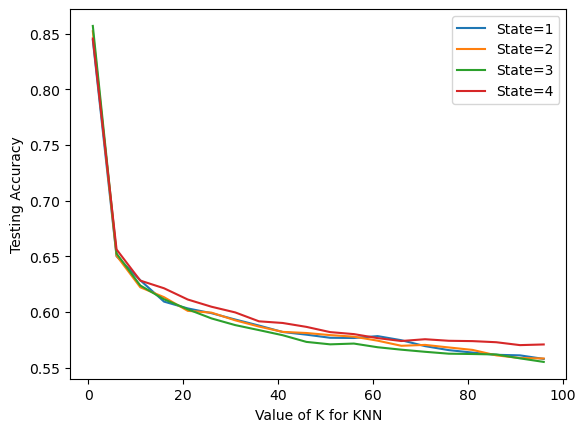

In [27]:
k_range = list(range(1, 100, 5))
random_states = list(range(1, 5))
for r in random_states:
    k_data = df.sample(n=10000, random_state=r)
    k_data = categorize_data(k_data)
    scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(k_data[selected_data], k_data["Broad_Crime_Code"])
        k_pred = knn.predict(k_data[selected_data])
        scores.append(accuracy_score(k_data["Broad_Crime_Code"], k_pred))
    plt.plot(k_range, scores, label=f'State={r}')

plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.legend();

<h1>Splitting the Dataset into Train and Test Sets </h1>

- We tested the accuracy score based on different n_neighbors and random_states.
- The optimal value of n_neighbors is approx. 24.

c:\Users\selen\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
c:\Users\selen\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

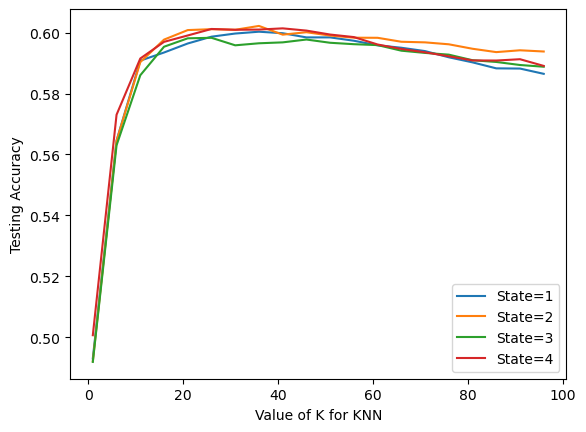

In [28]:
data = df.sample(n=100000, random_state=0)
data = categorize_data(data)
k_range = list(range(1, 100, 5))
random_states = list(range(1, 5, 1))
for r in random_states:
    data_train, data_test, target_train, target_test = train_test_split(data[selected_data], data["Broad_Crime_Code"], test_size=0.3, random_state=r)
    scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(data_train, target_train)
        target_pred = knn.predict(data_test)
        scores.append(accuracy_score(target_test, target_pred))
    plt.plot(k_range, scores, label=f'State={r}')

plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.legend();

- Efficiency is around 60 % with split data.

In [29]:
data_train, data_test, target_train, target_test = train_test_split(data[selected_data], data["Broad_Crime_Code"], test_size=0.3, random_state=2)

knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(data_train, target_train)
target_pred = knn.predict(data_test)
accuracy_score(target_test, target_pred)

c:\Users\selen\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.6021666666666666

C:\Users\selen\AppData\Local\Temp\ipykernel_16028\2424351016.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(confusion_matrix(target_test, target_pred)), cmap='Blues', interpolation='nearest')


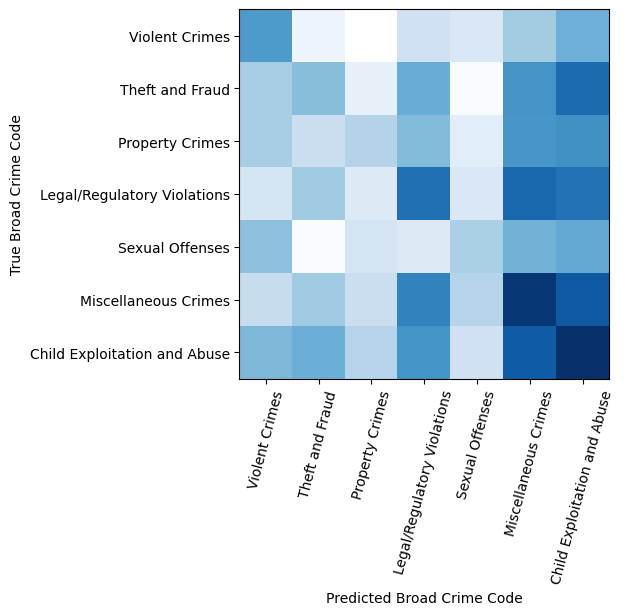

In [30]:
plt.imshow(np.log(confusion_matrix(target_test, target_pred)), cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.xticks(np.arange(7), target_test.unique(), rotation=75)
plt.yticks(np.arange(7), target_test.unique())
plt.ylabel('True Broad Crime Code')
plt.xlabel('Predicted Broad Crime Code');

- We proceeded with further analysis using different models as shown in the following code.

<h1>Linear Regression</h1>

- Showed really bad results

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


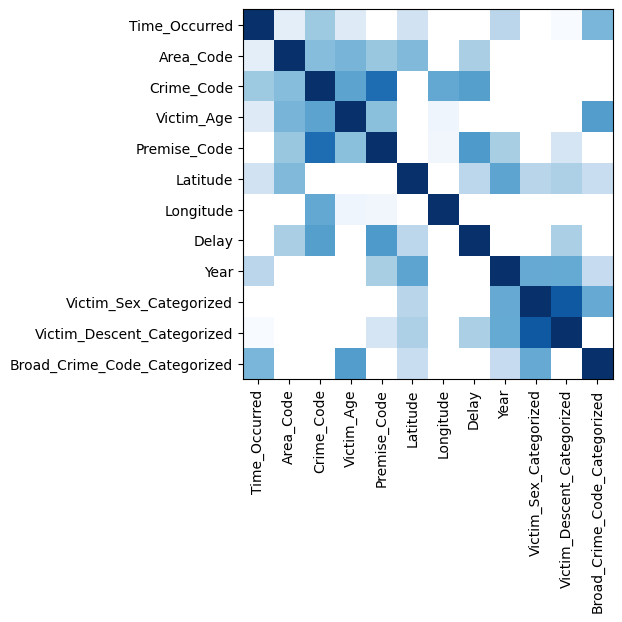

In [42]:
data = df.sample(n=100000, random_state=0)
data = categorize_data(data)

corr_matrix = data.corr(numeric_only=True)
plt.imshow(np.log(corr_matrix), cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.xticks(np.arange(corr_matrix.shape[1]), corr_matrix.index, rotation=90)
plt.yticks(np.arange(corr_matrix.shape[1]), corr_matrix.columns, rotation=0);

0.04586698763664754


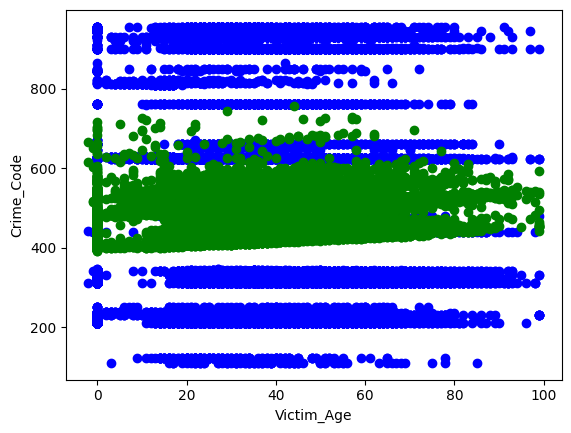

In [43]:
selected_data = [ 'Area_Code', 'Victim_Age', 'Premise_Code', 'Delay', 'Latitude', 'Longitude' ]
exogenous = prepare_reshape(data[selected_data])
endogenous = prepare_reshape(data["Crime_Code"])

data_train, data_test, target_train, target_test = train_test_split(exogenous, endogenous, test_size=0.3, random_state=0)

regr = LinearRegression()
regr.fit(data_train, target_train)
print(regr.score(data_test, target_test))
y_pred = regr.predict(data_test)

plt.scatter(data_test['Victim_Age'], target_test, color='b')
plt.scatter(data_test['Victim_Age'], y_pred, color='g')
plt.xlabel('Victim_Age')
plt.ylabel('Crime_Code')
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


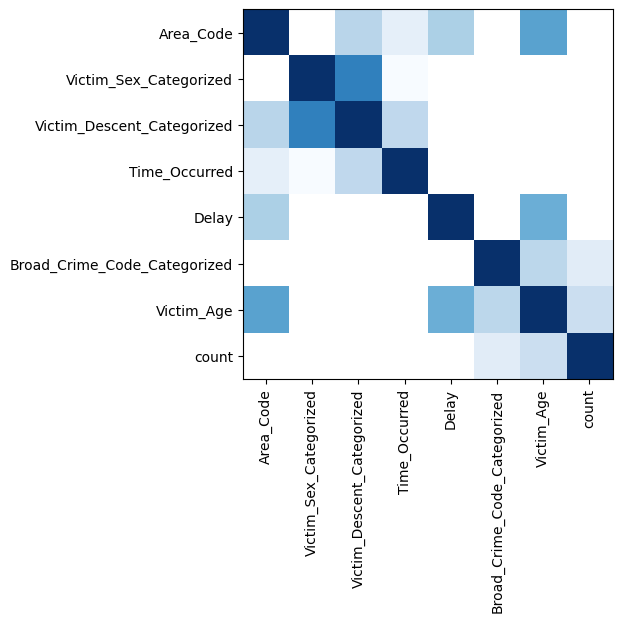

In [45]:
corr_matrix = grouped.corr(numeric_only=True)
plt.imshow(np.log(corr_matrix), cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.xticks(np.arange(corr_matrix.shape[1]), corr_matrix.index, rotation=90)
plt.yticks(np.arange(corr_matrix.shape[1]), corr_matrix.columns);

0.3156002778935556


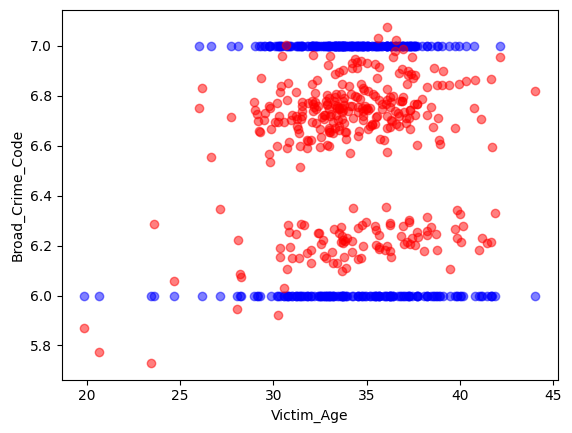

In [47]:
selected_data = [ 'Victim_Sex_Categorized', 'Time_Occurred', 'Delay', 'Victim_Descent_Categorized', 'Victim_Age', 'count' ]
exogenous = prepare_reshape(grouped[selected_data])
endogenous = prepare_reshape(grouped["Broad_Crime_Code_Categorized"])

data_train, data_test, target_train, target_test = train_test_split(exogenous, endogenous, test_size=0.3, random_state=0)

regr = LinearRegression()
regr.fit(data_train, target_train)
print(regr.score(data_test, target_test))
y_pred = regr.predict(data_test)

plt.scatter(data_test['Victim_Age'], target_test, color='b', alpha=0.5)
plt.scatter(data_test['Victim_Age'], y_pred, color='r', alpha=0.5)
# plt.scatter(data_test['Victim_Age'], y_pred.round(), color='g', alpha=0.5)
plt.xlabel('Victim_Age')
plt.ylabel('Broad_Crime_Code')
plt.show()

<h1>Logistic Regression</h1>


In [52]:
data = df.sample(n=100000, random_state=0)

data = categorize_data(data)
selected_data = [ 'Area_Code', 'Victim_Age', 'Premise_Code', 'Delay', 'Latitude', 'Longitude' ]
exogenous = prepare_reshape(data[selected_data])
endogenous = prepare_reshape(data["Broad_Crime_Code_Categorized"])

data_train, data_test, target_train, target_test = train_test_split(exogenous, endogenous, test_size=0.3, random_state=0)

regr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
regr.fit(data_train, target_train)
print(regr.score(data_test, target_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.4506


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.44465


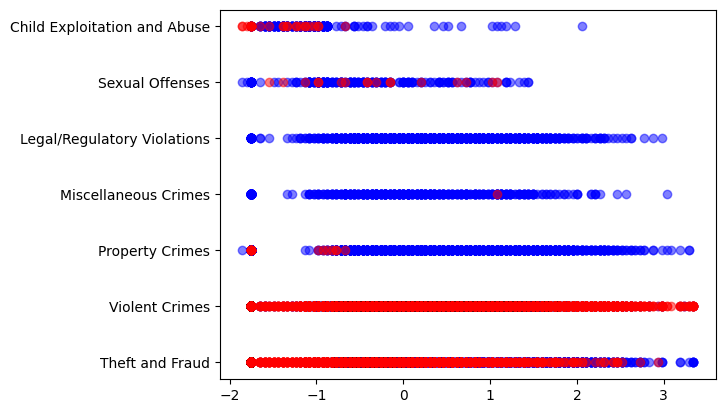

In [53]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(data[selected_data])

y = data['Broad_Crime_Code']  # Ensure this is encoded numerically
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(x_train, y_train)

accuracy = model.score(x_test, y_test)
print(f"Accuracy: {accuracy}")

y_pred = model.predict(x_test)
plt.scatter(x_test[:, 1], y_test, color='b', alpha=0.5)
plt.scatter(x_test[:, 1], y_pred, color='r', alpha=0.5)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


0.7771260997067448


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


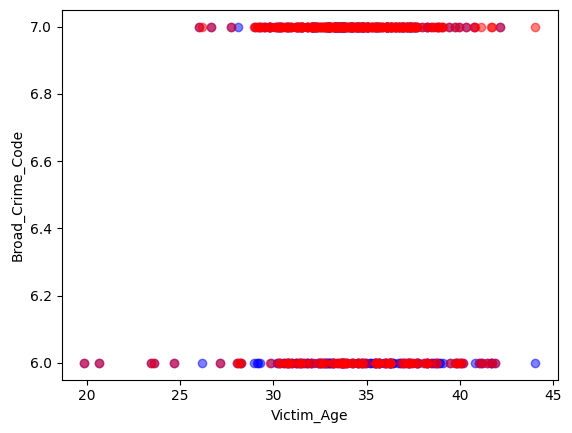

In [56]:
selected_data = [ 'Victim_Sex_Categorized', 'Time_Occurred', 'Delay', 'Victim_Descent_Categorized', 'Victim_Age', 'count' ]
exogenous = prepare_reshape(grouped[selected_data])
endogenous = prepare_reshape(grouped["Broad_Crime_Code_Categorized"])

data_train, data_test, target_train, target_test = train_test_split(exogenous, endogenous, test_size=0.3, random_state=0)

regr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
regr.fit(data_train, target_train)
print(regr.score(data_test, target_test))
y_pred = regr.predict(data_test)

plt.scatter(data_test['Victim_Age'], target_test, color='b', alpha=0.5)
plt.scatter(data_test['Victim_Age'], y_pred, color='r', alpha=0.5)
plt.xlabel('Victim_Age')
plt.ylabel('Broad_Crime_Code')
plt.show()

<h1>K-Means Clustering<h1>

Inertia: 9925.875226690563
Silhouette Score: 0.7084008710881968


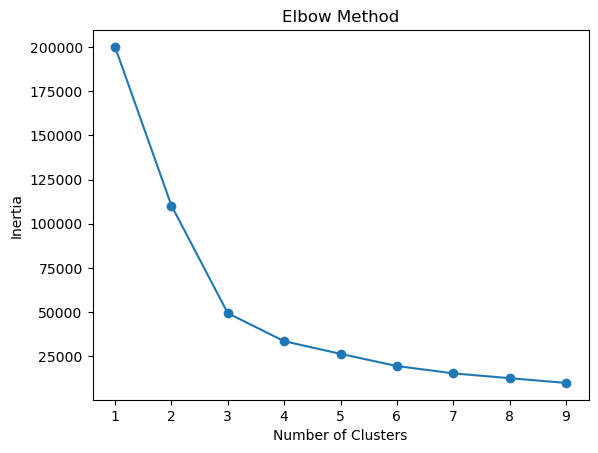

In [35]:
data = df.sample(n=100000, random_state=0).reset_index(drop=True)
data = categorize_data(data)
scaler = StandardScaler()
selected_data = ["Premise_Code", "Broad_Crime_Code_Categorized"]
scaled_data = scaler.fit_transform(data[selected_data])

data_train, data_test, target_train, target_test = train_test_split(scaled_data, np.ones(scaled_data.shape), test_size=0.3, random_state=0)

kmeans = KMeans(n_clusters=9, random_state=0).fit(scaled_data)
print("Inertia:", kmeans.inertia_)

score = silhouette_score(scaled_data, kmeans.labels_)
print("Silhouette Score:", score)

# Elbow Method
inertia_values = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    inertia_values.append(km.inertia_)

plt.plot(range(1, 10), inertia_values, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

Centers: [[168.44159201   3.83976568]
 [494.51075629   7.        ]
 [128.25414634   5.97936585]
 [517.89853896   1.58847403]
 [746.31469905   6.37238793]
 [462.87294651   5.94335195]
 [121.30909007   7.        ]
 [538.76443223   3.78600127]
 [128.47529976   1.66426859]]


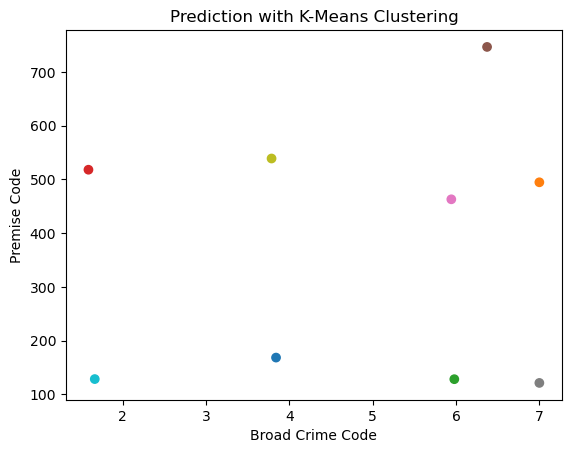

In [36]:
centers = km.cluster_centers_
original_centers = scaler.inverse_transform(centers)
print("Centers:", original_centers)

plt.scatter(original_centers[:,1], original_centers[:,0], c=range(len(original_centers)), cmap="tab10")
plt.title("Prediction with K-Means Clustering")
plt.xlabel("Broad Crime Code")
plt.ylabel("Premise Code")
plt.show()